# Bidirectional GRU Model for Stock Price Prediction

This file elaborates on an advanced implementation of a Bidirectional GRU (Gated Recurrent Unit) model, tailored for predicting stock prices with heightened accuracy by leveraging historical price data from both past and future contexts. The bidirectional approach enhances the standard GRU's capabilities, making it exceptionally adept for time series forecasting where understanding the full temporal context is crucial.

## Model Architecture

The Bidirectional GRU model extends the traditional GRU architecture by processing data in both forward and backward directions, thus enhancing its ability to capture dependencies that may influence the outcome at any given time step:

- **Bidirectional GRU Layers**: Implements a GRU that runs in two directions, doubling the network's capacity to capture information from both the past and the future states of the stock price series.
- **Input Layer**: Receives sequences of historical stock prices, processing the data in a manner that optimally prepares it for time series analysis.
- **Output Layer**: Utilizes a linear layer that consolidates outputs from both directions of the GRU, mapping them to a predicted future stock price.
- **Loss Function and Optimizer**: Employs Mean Squared Error (MSE) to evaluate the prediction accuracy and uses an Adam optimizer for effective weight adjustments based on the gradients.

## Forecasting Process

The forecasting methodology for the Bidirectional GRU model comprises several steps designed to ensure that the predictions are both accurate and robust:

1. **Data Preparation**: Similar to the unidirectional model, data is first normalized using MinMax scaling. It is then segmented into sequences that the bidirectional model will utilize, considering both preceding and subsequent data points.
   
2. **Model Initialization**: The model is configured with specific parameters such as the learning rate, number of GRU layers, size of each layer, and directionality settings.

3. **Training Loop**: The model undergoes training over multiple epochs, during which it processes the bidirectional data, computes the loss, and iteratively refines the model weights to minimize prediction errors.

4. **Evaluation**: Post-training, the model is evaluated using a distinct testing dataset to verify its ability to predict under varied, real-world conditions effectively.

5. **Visualization**: Results, including predictions and actual stock prices, are visually represented using interactive charts to facilitate a detailed comparison of the model's performance.

## Advantages Over Unidirectional GRU

The bidirectional model offers distinct advantages:

1. **Enhanced Contextual Understanding**: By processing data from both past and future contexts, the model garners a more comprehensive understanding of the time series data.
   
2. **Improved Accuracy**: This comprehensive temporal insight generally results in more accurate and reliable predictions, especially in complex scenarios where future context significantly influences the outcomes.

3. **Robustness**: The bidirectional approach typically provides more stability and consistency across different data and testing scenarios, making it ideal for financial applications where precision is crucial.

## Usage Instructions

Using the Bidirectional GRU model follows a similar procedure to the unidirectional one but expects an understanding of handling bidirectional data flows:

1. **Load and Prepare Data**: Import and normalize the dataset. Ensure data sequences are prepared to accommodate bidirectional processing.
   
2. **Set Model Parameters**: Configure settings like learning rate, number of layers, and the bidirectionality of the GRU.
   
3. **Instantiate and Train the Model**: Create an instance of the Bidirectional GRU model and commence the training with the prepared sequences.
   
4. **Evaluate and Visualize**: Post-training, assess the model's performance on the testing set and visualize the outcomes for detailed analysis.

## Requirements

- Python 3.x
- PyTorch
- NumPy
- Pandas
- Plotly

This Bidirectional GRU model represents a sophisticated tool for stock price forecasting, providing financial analysts and data scientists with a potent means to exploit both past and future data patterns for making informed, strategic predictions in stock markets.

In [7]:
# !pip install yfinance tensorflow keras numpy matplotlib seaborn tqdm scikit-learn graphviz

In [1]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import plotly.graph_objects as go


# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [2]:
# stock configs
ticker = ['TSLA']
start_date = '2014-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [3]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2520, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-04-01,13.934667,14.544000,13.905333,14.464667,110571000,0.0,0.0
1,2014-04-02,14.666667,15.392667,14.536667,15.352667,161734500,0.0,0.0
2,2014-04-03,15.353333,15.715333,14.800000,15.026667,163855500,0.0,0.0
3,2014-04-04,15.067333,15.218000,14.083333,14.148667,170184000,0.0,0.0
4,2014-04-07,13.720667,14.413333,13.567333,13.834667,147832500,0.0,0.0


# Model Implementation

Below we implement the model, first we separate the data into a train-test split.  For this LSTM model, we will leverage continuous windows of time for training and test data.


In [4]:
scaler = MinMaxScaler()
minmax = scaler.fit(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.012205
1,0.014423
2,0.013608
3,0.011415
4,0.010631


In [5]:
simulation_size = 5
lookback = 30
train_len = int(included_days * train_size)
test_len = included_days - train_len

df_train = df_log.iloc[:train_len]
df_test = df_log.iloc[train_len:]


def create_dataset(X, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X)-look_back):
        a = X[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(X[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

lookback = 30  # this variable was previously defined but not used in your example
X_train, y_train = create_dataset(df_train.values, lookback)
X_test, y_test = create_dataset(df_test.values, lookback)

# Adjust for LSTM input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias=0.1):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.size_layer = size_layer
        self.output_size = output_size
        self.dropout = forget_bias
        
        # Define the bidirectional GRU layers
        self.gru = nn.GRU(size, size_layer, num_layers, batch_first=True, 
                          dropout=1-forget_bias, bidirectional=True)
        # Adjust the input size of the linear layer to handle bidirectional output
        self.linear = nn.Linear(2 * size_layer, output_size)
        
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, hidden):
        x, h = self.gru(x, hidden)
        # Adjust how to take output: we concatenate the outputs from both directions
        x = self.linear(x[:, -1])
        return x, h

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros for both directions
        return torch.zeros(self.num_layers * 2, batch_size, self.size_layer)

def calculate_accuracy(real, predict):
    real = torch.tensor(real) + 1
    predict = torch.tensor(predict) + 1
    percentage = 1 - torch.sqrt(torch.mean(torch.pow((real - predict) / real)))
    return percentage.item() * 100

In [13]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [14]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 20
dropout_rate = 0.8
future_day = 60
learning_rate = 0.01

In [15]:
def forecast(model, X_train, y_train, X_test, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Assuming X_train is correctly shaped [batch_size, seq_length, num_features]
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)

    for epoch in range(epochs):
        model.optimizer.zero_grad()
        # Here, ensure batch_size is correctly reflected
        hidden = model.init_hidden(X_train_tensor.size(0)).to(device)
        outputs, _ = model(X_train_tensor, hidden)
        loss = model.loss_fn(outputs, y_train_tensor)
        loss.backward()
        model.optimizer.step()
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss {loss.item()}')

    # Evaluation
    model.eval()
    # Ensure X_test is shaped and batched correctly
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    hidden = model.init_hidden(X_test_tensor.size(0)).to(device)
    with torch.no_grad():
        test_pred, _ = model(X_test_tensor, hidden)
    
    return test_pred.squeeze().cpu().numpy()


In [16]:
def run_model_iterations(n_iterations, X_train, y_train, X_test):
    predictions = []
    for _ in range(n_iterations):
        # Initialize the model
        model = Model(learning_rate=0.01, num_layers=1, size=1, size_layer=128, output_size=1, forget_bias=0.1)
        
        # Train and predict
        preds = forecast(model, X_train, y_train, X_test)
        arr = scaler.inverse_transform(preds.reshape(-1, 1)).tolist()
        arr = [p[0] if isinstance(p, list) else p for p in arr]
        predictions.append(arr)
    
    return predictions

In [23]:
# Run the model multiple times
n_iterations = 5
test_start_date = datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=test_len - 1)
model_predictions = run_model_iterations(n_iterations, X_train, y_train, X_test)
actual_data = y_test.flatten()
dates = pd.date_range(start=test_start_date, periods=len(y_test), freq='D')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.0819404199719429
Epoch 5 Loss 0.004633889067918062
Epoch 10 Loss 0.002217296976596117
Epoch 15 Loss 0.0003851400106213987


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.08557923883199692
Epoch 5 Loss 0.009138844907283783
Epoch 10 Loss 0.0011761767091229558
Epoch 15 Loss 0.0008496255031786859


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.07158315181732178
Epoch 5 Loss 0.008397025987505913
Epoch 10 Loss 0.0018645240925252438
Epoch 15 Loss 0.0003335140354465693


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.06188376247882843
Epoch 5 Loss 0.013610525988042355
Epoch 10 Loss 0.008136161603033543
Epoch 15 Loss 0.00448610307648778


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1



Epoch 0 Loss 0.08104550838470459
Epoch 5 Loss 0.005638918839395046
Epoch 10 Loss 0.0005637846188619733
Epoch 15 Loss 0.00048190541565418243


In [24]:

print(model_predictions[0])


[273.900634765625, 263.7529602050781, 272.4044494628906, 259.5998229980469, 256.90643310546875, 243.27902221679688, 243.3533172607422, 230.189453125, 235.99127197265625, 250.73770141601562, 268.86126708984375, 272.90423583984375, 268.99755859375, 277.5470886230469, 259.07171630859375, 258.2646179199219, 258.0989990234375, 260.7082214355469, 259.63238525390625, 253.27117919921875, 238.0501708984375, 238.82789611816406, 248.83847045898438, 234.71209716796875, 234.997314453125, 251.5947723388672, 254.6110382080078, 254.8791046142578, 263.74432373046875, 264.8843078613281, 254.96212768554688, 249.16378784179688, 244.21315002441406, 245.39739990234375, 250.55081176757812, 250.76487731933594, 261.71234130859375, 269.3211669921875, 257.4228820800781, 253.73550415039062, 255.78440856933594, 257.25726318359375, 259.21014404296875, 260.129150390625, 264.54864501953125, 267.16412353515625, 288.1343994140625, 293.22222900390625, 291.50201416015625, 282.8721008300781, 294.1270751953125, 301.4524536

In [25]:

# Creating traces for the actual and predicted stock prices
trace_actual = go.Scatter(
    x=dates,
    y=data['Close'].iloc[train_len:].values,
    mode='lines',
    name='Actual Price',
    line=dict(color='blue', width=2)
)

traces_predicted = []
for i, preds in enumerate(model_predictions):
    trace_predicted = go.Scatter(
        x=dates,
        y=preds,
        mode='lines',
        name=f'Predicted Price (Iteration {i+1})',
        line=dict(color=f'rgba(255, 0, 0, {1 - i*0.12})', dash='dot', width=2)  # Adjust opacity for clarity
    )
    traces_predicted.append(trace_predicted)

# Create the layout and figure
layout = go.Layout(
    title='Stock Price Prediction (During Test Period)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template='plotly_dark'
)

fig = go.Figure(data=[trace_actual] + traces_predicted, layout=layout)
fig.show()

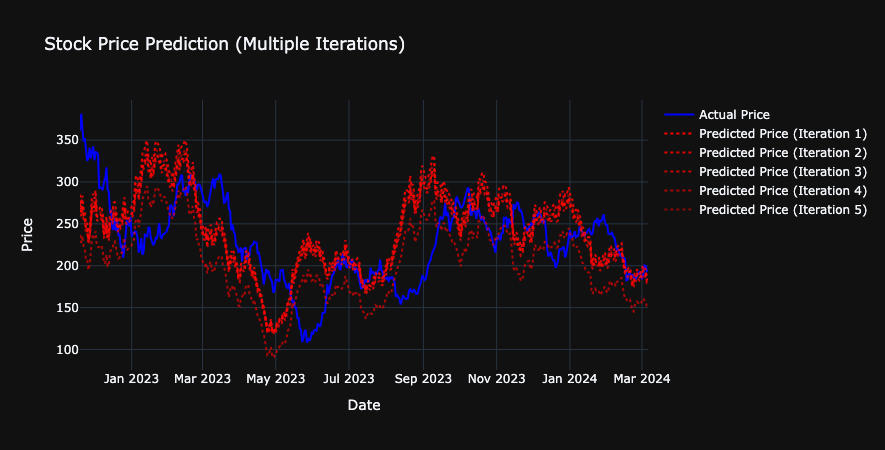